# Previsão de churn (abandono) em telecom

### Referências:
- https://github.com/RomeroBarata/IF702-redes-neurais

### Grupo 8:
- Erbert Gadelha (ebgr)
- João Pedro (jpba)
- Vinicius Barbosa (vrb)
- Almir Alves (aasc)
- Felipe Mateus (fmfb)

# Preparação e importação da base de dados

In [111]:
#@title Instalações

# scikit plot
!pip install scipy==1.11.4 scikit-plot

# optuna
!pip install optuna
!pip install optuna-integration[tfkeras]

# tabpfn
!pip install tabpfn
# !pip uninstall -y tensorflow keras
!pip install tensorflow==2.15.0
# !pip install tensorflow==2.19.0

# STab
!pip install keras4torch
!pip install einops
!pip install tab-transformer-pytorch

!git clone https://github.com/kailanefelix/stab-redes-neurais.git

!ls
%cd stab-redes-neurais
!mv STAB STab

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.9/98.9 kB 6.4 MB/s eta 0:00:00
Cloning into 'stab-redes-neurais'...
remote: Enumerating objects: 97, done.
remote: Counting objects: 100% (97/97), done.
remote: Compressing objects: 100% (87/87), done.
remote: Total 97 (delta 43), reused 20 (delta 3), pack-reused 0 (from 0)
Receiving objects: 100% (97/97), 62.40 KiB | 3.90 MiB/s, done.
Resolving deltas: 100% (43/43), done.
Data  README.md  saved	STab  stab-redes-neurais  train_tutorial.ipynb
/content/stab-redes-neurais/stab-redes-neurais


In [112]:
#@title Importações
# basic
import kagglehub
import numpy as np
import numpy.typing as npt
import pandas as pd

# visualization
import matplotlib.pyplot as plt
import seaborn as sns

import scikitplot as skplt

# sklearn
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, recall_score, precision_score, f1_score, mean_squared_error

# SMOTE
from imblearn.over_sampling import SMOTE

# tensorflow
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# optuna
import optuna
from optuna.integration import TFKerasPruningCallback

# Keras4Torch
import keras4torch
from keras4torch.callbacks import ModelCheckpoint, LRScheduler

# tabpfn
from tabpfn import TabPFNClassifier

# STab
import STab
from STab import mainmodel, LWTA, Gsoftmax, Num_Cat
from einops import rearrange
from tab_transformer_pytorch import TabTransformer

# fix random seed
tf.random.set_seed(42)
np.random.seed(42)

In [3]:
#@title Download data and create DataFrame
churn_data_path = kagglehub.dataset_download("kapturovalexander/customers-churned-in-telecom-services")
print("Path to dataset files:", churn_data_path)

churn_df = pd.read_csv(churn_data_path + "/customer_churn_telecom_services.csv")
print(f"Data shape {churn_df.shape}")
churn_df.head()

Path to dataset files: /kaggle/input/customers-churned-in-telecom-services
Data shape (7043, 20)


,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


# Exploração dos dados

### Descrição das colunas:

| Column Name | Description |
|-------------|-------------|
| gender | Customer's gender (Male/Female) |
| SeniorCitizen |	Indicates if the customer is a senior citizen (1 = Yes, 0 = No) |
| Partner | Whether the customer has a partner (Yes/No) |
| Dependents | Whether the customer has dependents (Yes/No) |
|tenure |	Number of months the customer has stayed with the company |
|PhoneService |	Whether the customer has a phone service (Yes/No) |
|MultipleLines | Whether the customer has multiple phone lines (No, Yes, No phone service) |
|InternetService | Type of internet service (DSL, Fiber optic, No) |
|OnlineSecurity |	Whether the customer has online security (Yes, No, No internet service) |
|OnlineBackup |	Whether the customer has online backup (Yes, No, No internet service) |
|DeviceProtection |	Whether the customer has device protection (Yes, No, No internet service) |
|TechSupport | Whether the customer has tech support (Yes, No, No internet service) |
|StreamingTV | Whether the customer has streaming TV (Yes, No, No internet service) |
|StreamingMovies |	Whether the customer has streaming movies (Yes, No, No internet service) |
|Contract |	Type of contract (Month-to-month, One year, Two year) |
|PaperlessBilling |	Whether the customer has paperless billing (Yes/No) |
|PaymentMethod | Payment method used (Electronic check, Mailed check, Bank transfer, Credit card) |
|MonthlyCharges |	Monthly charges the customer pays |
|TotalCharges |	Total amount charged to the customer |
|Churn |	Whether the customer has churned (Yes/No) |

## Verificando valores nulos

In [4]:
#@title Verificando o dataset
churn_df.info()
nulls = churn_df['TotalCharges'].isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7043 non-null   object 
 1   SeniorCitizen     7043 non-null   int64  
 2   Partner           7043 non-null   object 
 3   Dependents        7043 non-null   object 
 4   tenure            7043 non-null   int64  
 5   PhoneService      7043 non-null   object 
 6   MultipleLines     7043 non-null   object 
 7   InternetService   7043 non-null   object 
 8   OnlineSecurity    7043 non-null   object 
 9   OnlineBackup      7043 non-null   object 
 10  DeviceProtection  7043 non-null   object 
 11  TechSupport       7043 non-null   object 
 12  StreamingTV       7043 non-null   object 
 13  StreamingMovies   7043 non-null   object 
 14  Contract          7043 non-null   object 
 15  PaperlessBilling  7043 non-null   object 
 16  PaymentMethod     7043 non-null   object 


A colunas `TotalCharges` possui 11 valores nulos, portanto essas amostras serão removidas.

In [5]:
#@title Removendo valores nulos
print(f"Data shape (before cleaning) {churn_df.shape}")
churn_df = churn_df.dropna()
print(f"Data shape (after cleaning) {churn_df.shape}")

Data shape (before cleaning) (7043, 20)
Data shape (after cleaning) (7032, 20)


## Verificando outliers

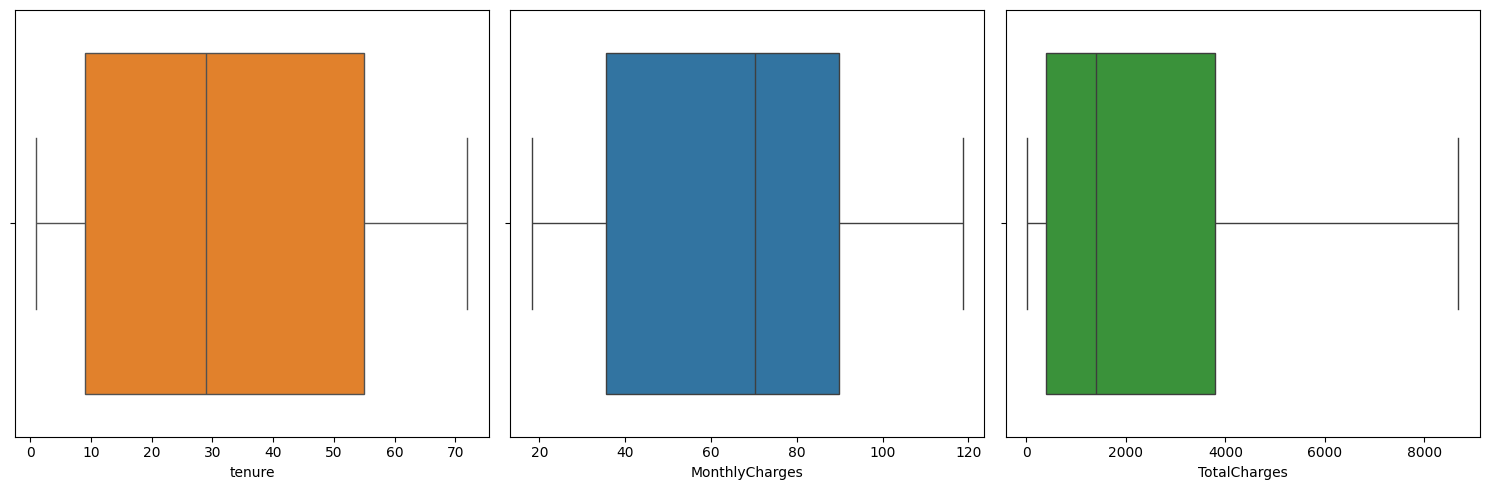

In [6]:
#@title Verificando a existência de outliers

numerical_features = ['tenure', 'MonthlyCharges', 'TotalCharges']
colors = ['tab:orange', 'tab:blue', 'tab:green']
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for i, feature in enumerate(numerical_features):
  sns.boxplot(churn_df, x=feature, ax=axes[i], color=colors[i])
plt.tight_layout()

In [68]:
#@title Removendo outliers

print(f"Data shape (before cleaning) {churn_df.shape}")

treshold = 3
for feature in numerical_features:
  mean = churn_df[feature].mean()
  std = churn_df[feature].std()
  z_scores = (churn_df[feature] - mean) / std
  churn_df = churn_df[(np.abs(z_scores) < treshold)]

print(f"Data shape (after cleaning) {churn_df.shape}")

Data shape (before cleaning) (7032, 41)
Data shape (after cleaning) (7032, 41)


## Analisando distribuições

### Features Contínuas

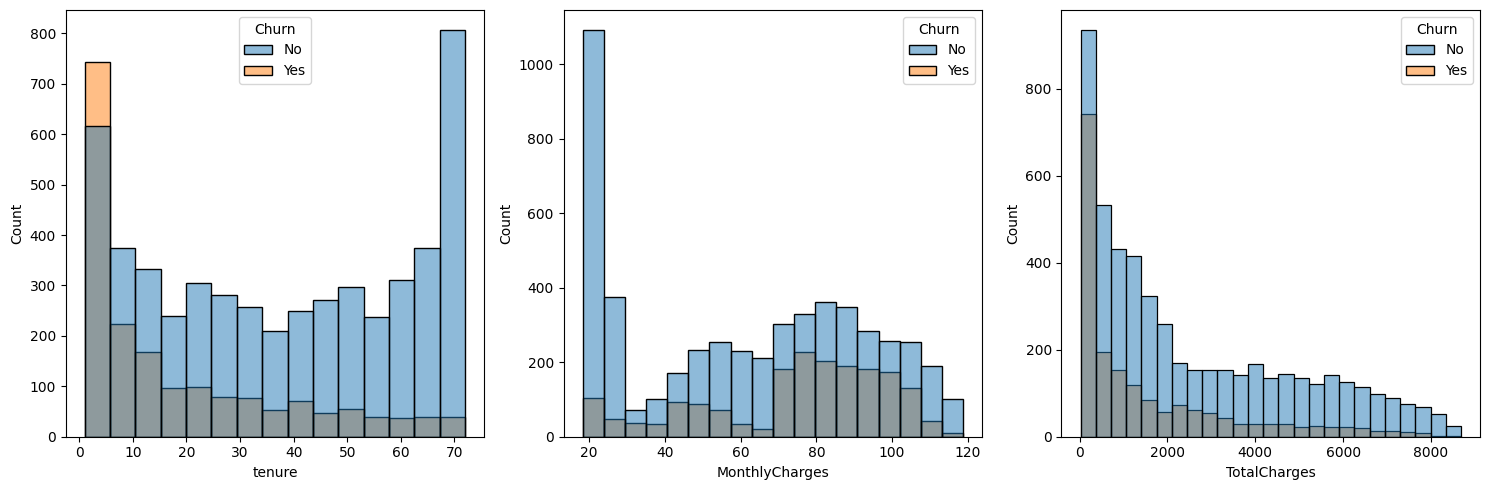

In [7]:
#@title Histograma por abandono

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for i, feature in enumerate(numerical_features):
  sns.histplot(churn_df, x=feature, ax=axes[i], hue='Churn')
plt.tight_layout()
plt.show()

A partir das distribuições podemos deduzir os seguintes pontos:
*   Clientes jovens tendem a abandonar mais, enquanto pessoas com mais idade tendem a continuar sendo clientes
*   Cobranças mensais muito baixas contribuem para uma alta taxa de fidelidade, mas valores mais altos não apresentam uma influência notável



### Classes

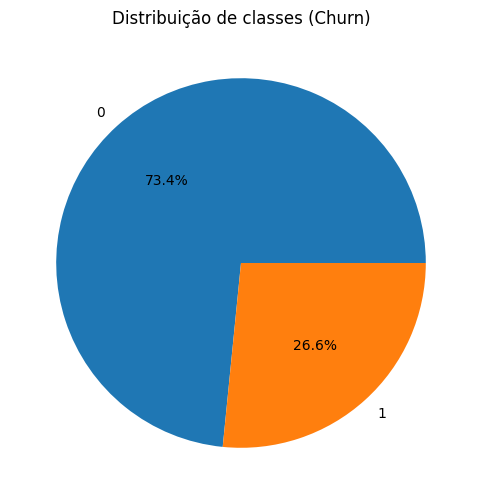

In [71]:
#@title Distribuição de classes

plt.figure(figsize=(6, 6))
churn_df['Churn'].value_counts().plot(kind='pie', autopct='%1.1f%%')
plt.title('Distribuição de classes (Churn)')
plt.ylabel('')
plt.show()

Distribuição antes do balanceamento: [5163 1869]
Distribuição após balanceamento: [5163 5163]


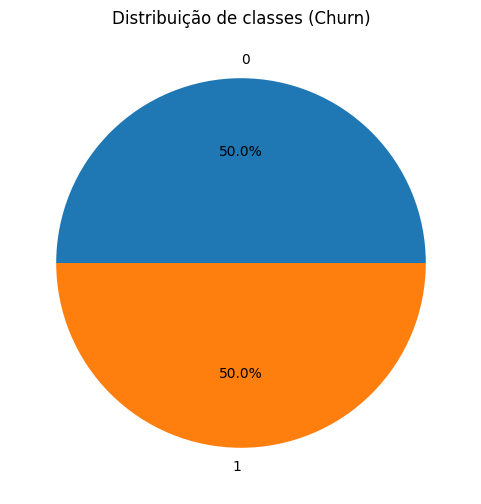

In [75]:
#@title Balanceamento de classes

smote = SMOTE(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(churn_df.drop(columns=['Churn']), churn_df['Churn'])

print(f"Distribuição antes do balanceamento: {np.bincount(churn_df['Churn'])}")
print(f"Distribuição após balanceamento: {np.bincount(y_train_bal)}")

# save results to original dataframe
churn_df = pd.concat([X_train_bal, y_train_bal], axis=1)

# plot new distribution
plt.figure(figsize=(6, 6))
churn_df['Churn'].value_counts().plot(kind='pie', autopct='%1.1f%%')
plt.title('Distribuição de classes (Churn)')
plt.ylabel('')
plt.show()

# Preparação dos dados

In [76]:
#@title Convertendo tipos categóricos

cat_df = churn_df.select_dtypes(include=['object', 'category'])
for col in cat_df.columns:
  churn_df[col] = churn_df[col].astype('category')
  churn_df[col] = churn_df[col].cat.codes

  if col == 'Churn':
    continue

  # one hot encode if more than 2 alternatives
  if len(churn_df[col].unique()) > 2:
    churn_df = pd.concat([churn_df, pd.get_dummies(churn_df[col], prefix=col)], axis=1)
    churn_df = churn_df.drop(columns=[col])

churn_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10326 entries, 0 to 10325
Data columns (total 41 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   gender              10326 non-null  int8   
 1   SeniorCitizen       10326 non-null  int64  
 2   Partner             10326 non-null  int8   
 3   Dependents          10326 non-null  int8   
 4   tenure              10326 non-null  int64  
 5   PhoneService        10326 non-null  int8   
 6   PaperlessBilling    10326 non-null  int8   
 7   MonthlyCharges      10326 non-null  float64
 8   TotalCharges        10326 non-null  float64
 9   MultipleLines_0     10326 non-null  bool   
 10  MultipleLines_1     10326 non-null  bool   
 11  MultipleLines_2     10326 non-null  bool   
 12  InternetService_0   10326 non-null  bool   
 13  InternetService_1   10326 non-null  bool   
 14  InternetService_2   10326 non-null  bool   
 15  OnlineSecurity_0    10326 non-null  bool   
 16  Onli

In [77]:
#@title Divisão estratificada Treino / Validação / Teste (50% / 25% / 25%)
X = churn_df.drop(columns=['Churn'])
y = churn_df['Churn']

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.5, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

print(f"Train shape {X_train.shape}")
print(f"Validation shape {X_val.shape}")
print(f"Test shape {X_test.shape}")

Train shape (5163, 40)
Validation shape (2581, 40)
Test shape (2582, 40)


In [78]:
#@title Normalização das features numéricas

mean_train = X_train.mean()
std_train = X_train.std()

X_train_n = X_train.copy(deep=True)
X_val_n = X_val.copy(deep=True)
X_test_n = X_test.copy(deep=True)

for col in numerical_features:
  X_train_n[col] = (X_train[col] - mean_train[col]) / std_train[col]
  X_val_n[col] = (X_val[col] - mean_train[col]) / std_train[col]
  X_test_n[col] = (X_test[col] - mean_train[col]) / std_train[col]

print("===========================================================================")
print("Distribuições do conjunto de treino")
print("===========================================================================")
print(X_train.describe())
print("===========================================================================")
print("Distribuições (normalizadas) do conjunto de treino")
print("===========================================================================")
print(X_train_n.describe())

Distribuições do conjunto de treino
            gender  SeniorCitizen      Partner   Dependents       tenure  \
count  5163.000000    5163.000000  5163.000000  5163.000000  5163.000000   
mean      0.425334       0.135386     0.379431     0.217897    27.883014   
std       0.494441       0.342169     0.485292     0.412857    23.810701   
min       0.000000       0.000000     0.000000     0.000000     1.000000   
25%       0.000000       0.000000     0.000000     0.000000     5.000000   
50%       0.000000       0.000000     0.000000     0.000000    22.000000   
75%       1.000000       0.000000     1.000000     0.000000    48.000000   
max       1.000000       1.000000     1.000000     1.000000    72.000000   

       PhoneService  PaperlessBilling  MonthlyCharges  TotalCharges  
count   5163.000000       5163.000000     5163.000000   5163.000000  
mean       0.895410          0.595003       68.189951   2066.284056  
std        0.306054          0.490939       28.736887   2176.431980  

In [79]:
#@title Conversão para numpy

X_train_n = X_train_n.astype(np.float32).to_numpy()
X_val_n = X_val_n.astype(np.float32).to_numpy()
X_test_n = X_test_n.astype(np.float32).to_numpy()

y_train = y_train.astype(np.float32).to_numpy()
y_val = y_val.astype(np.float32).to_numpy()
y_test = y_test.astype(np.float32).to_numpy()

# Métodos auxiliares

In [80]:
#@title Plot do Teste Kolmogorov-Smirnov

def plot_ks(y_true: npt.NDArray, y_pred: npt.NDArray):
  skplt.metrics.plot_ks_statistic(y_true, y_pred)
  plt.show()

In [81]:
#@title Plot da Matriz de Confusão

def plot_conf_matrix(cm):
  sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
  plt.xlabel('Predicted')
  plt.ylabel('True')
  plt.show()

In [82]:
#@title Plot da curva ROC

def plot_roc(fpr, tpr, auc, label):
  plt.figure(figsize=(6, 6))
  plt.plot(fpr, tpr, label=f'{label} (AUC = {auc:.2f})')
  plt.plot([0, 1], [0, 1], '--', color='tab:orange')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.legend(loc="lower right")
  plt.show()

In [83]:
#@title Plot das curvas de erro do treinamento

def plot_training_error_curves(history, loss):
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']

    fig, ax = plt.subplots()
    ax.plot(train_loss, label='Train')
    ax.plot(val_loss, label='Validation')
    ax.set(title='Training and Validation Error Curves', xlabel='Epochs', ylabel=f'Loss ({loss})')
    ax.legend()
    plt.show()

In [84]:
#@title Callback de pruning do optuna
class OptunaPruningCallback(keras4torch.callbacks.Callback):
  def __init__(self, trial, monitor='val_roc_auc'):
    super().__init__()
    self.trial = trial
    self.monitor = monitor

  def on_epoch_end(self, trainer):
    epoch = trainer.epoch
    intermediate_value = trainer.logger.metrics.get(self.monitor, None)

    if intermediate_value is not None:
        self.trial.report(intermediate_value, epoch)

    # Check if the trial should be pruned
    if self.trial.should_prune():
        raise optuna.exceptions.TrialPruned()

# Execução inicial com classificadores

In [85]:
#@title Parâmetros gerais
epochs = 10000
patience = 20

## MLP

In [86]:
#@title Definição do modelo
mlp_classifier = Sequential()
mlp_classifier.add(Input(shape=(X_train.shape[1],)))
mlp_classifier.add(Dense(10, activation='relu'))
mlp_classifier.add(Dense(1, activation='sigmoid'))
mlp_classifier.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
mlp_classifier.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 10)                410       
                                                                 
 dense_3 (Dense)             (None, 1)                 11        
                                                                 
Total params: 421 (1.64 KB)
Trainable params: 421 (1.64 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [87]:
#@title Treinamento inicial
mlp_history = mlp_classifier.fit(X_train_n, y_train, epochs=epochs, validation_data=(X_val_n, y_val),
                                 callbacks=[EarlyStopping(patience=patience, monitor='val_loss')])

Epoch 1/10000
162/162 [==============================] - 1s 3ms/step - loss: 0.1975 - val_loss: 0.1590
Epoch 2/10000
162/162 [==============================] - 0s 2ms/step - loss: 0.1482 - val_loss: 0.1450
Epoch 3/10000
162/162 [==============================] - 0s 2ms/step - loss: 0.1393 - val_loss: 0.1401
Epoch 4/10000
162/162 [==============================] - 0s 3ms/step - loss: 0.1349 - val_loss: 0.1370
Epoch 5/10000
162/162 [==============================] - 0s 2ms/step - loss: 0.1319 - val_loss: 0.1340
Epoch 6/10000
162/162 [==============================] - 0s 2ms/step - loss: 0.1292 - val_loss: 0.1319
Epoch 7/10000
162/162 [==============================] - 0s 2ms/step - loss: 0.1271 - val_loss: 0.1303
Epoch 8/10000
162/162 [==============================] - 0s 2ms/step - loss: 0.1251 - val_loss: 0.1289
Epoch 9/10000
162/162 [==============================] - 0s 3ms/step - loss: 0.1236 - val_loss: 0.1266
Epoch 10/10000
162/162 [==============================] - 0s 2ms/step - l

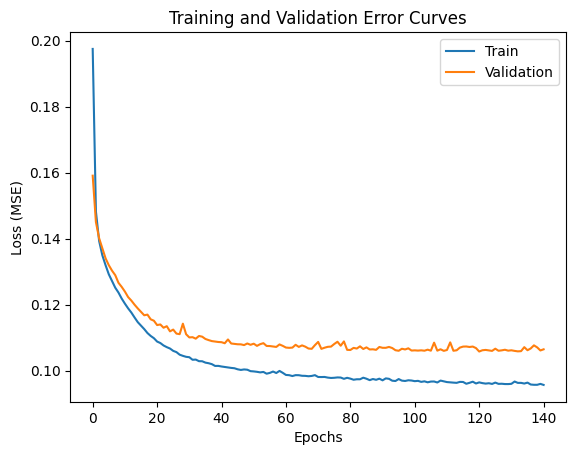

In [88]:
#@title Curvas de aprendizado

plot_training_error_curves(mlp_history, 'MSE')

### Avaliação inicial

In [89]:
#@title Gerando predições
mlp_preds = mlp_classifier.predict(X_test_n)
mlp_preds_scores_0 = 1 - mlp_preds
mlp_preds_scores = np.concatenate([mlp_preds_scores_0, mlp_preds], axis=1)

81/81 [==============================] - 0s 1ms/step


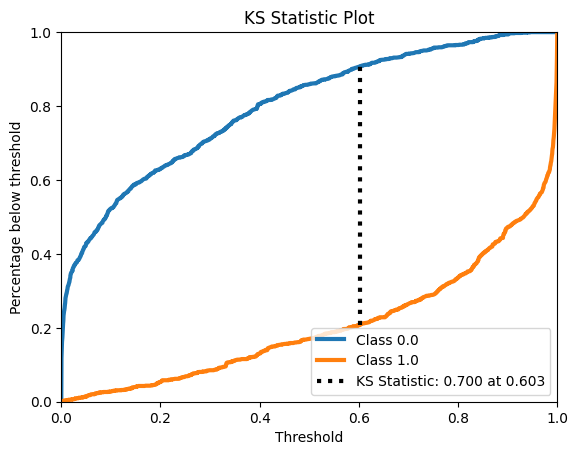

In [90]:
#@title Teste Kolmogorov-Smirnov
plot_ks(y_test, mlp_preds_scores)

In [91]:
#@title MSE
mlp_mse = mlp_classifier.evaluate(X_test_n, y_test, verbose=0)
print(f"MSE: {mlp_mse}")

MSE: 0.10703110694885254


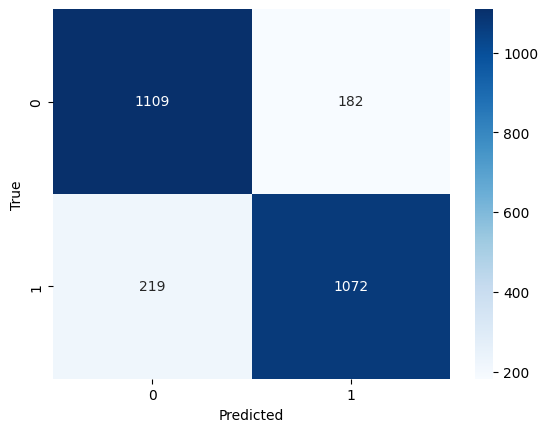

In [92]:
#@title Matriz de confusão
mlp_cm = confusion_matrix(y_test, np.round(mlp_preds))
plot_conf_matrix(mlp_cm)

AUC-ROC: 0.9300988011503101


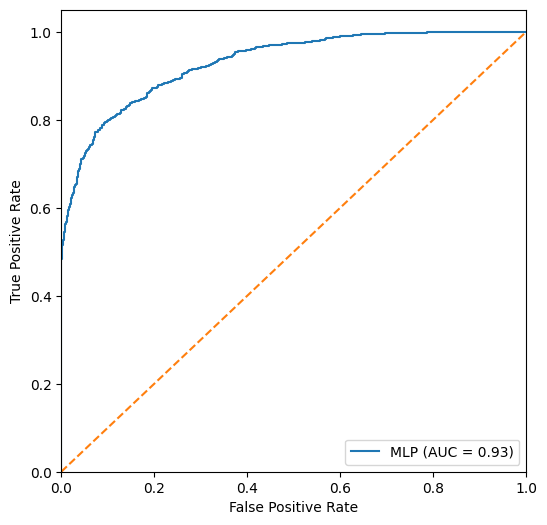

In [93]:
#@title AUC-ROC
mlp_auc = roc_auc_score(y_test, mlp_preds)
print(f"AUC-ROC: {mlp_auc}")
mlp_fpr, mlp_tpr, _ = roc_curve(y_test, mlp_preds)
plot_roc(mlp_fpr, mlp_tpr, mlp_auc, 'MLP')

In [94]:
#@title Recall, precision e f-score
mlp_recall = recall_score(y_test, np.round(mlp_preds))
mlp_precision = precision_score(y_test, np.round(mlp_preds))
mlp_f1 = f1_score(y_test, np.round(mlp_preds))
print(f"Recall: {mlp_recall}")
print(f"Precision: {mlp_precision}")
print(f"F1-score: {mlp_f1}")

Recall: 0.8303640588690937
Precision: 0.8548644338118022
F1-score: 0.8424361493123772


## Random Forest

In [95]:
#@title Definição do modelo
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier

RandomForestClassifier(random_state=42)

In [96]:
#@title Treinamento inicial
rf_classifier.fit(X_train_n, y_train)

RandomForestClassifier(random_state=42)

### Avaliação inicial

In [97]:
#@title Gerando predições
rf_preds = rf_classifier.predict(X_test_n)
rf_preds_0 = 1 - rf_preds
rf_preds_scores = np.concatenate([rf_preds_0.reshape(-1, 1), rf_preds.reshape(-1, 1)], axis=1)
print(f"Predições: {rf_preds.shape}")

Predições: (2582,)


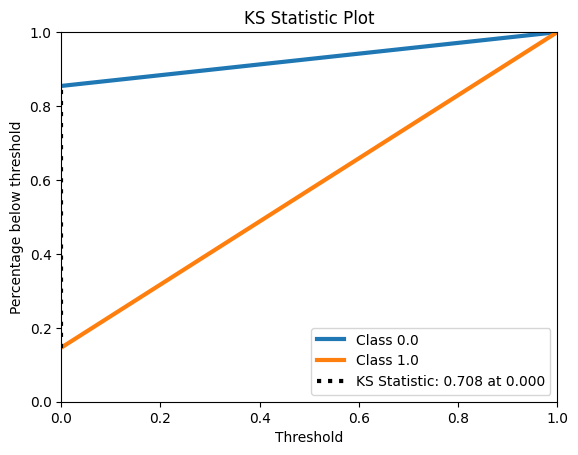

In [98]:
#@title Teste Kolmogorov-Smirnov
rf_ks = plot_ks(y_test, rf_preds_scores)

In [99]:
#@title MSE
rf_mse = mean_squared_error(y_test, rf_preds)
print(f"MSE: {rf_mse}")

MSE: 0.1460108458995819


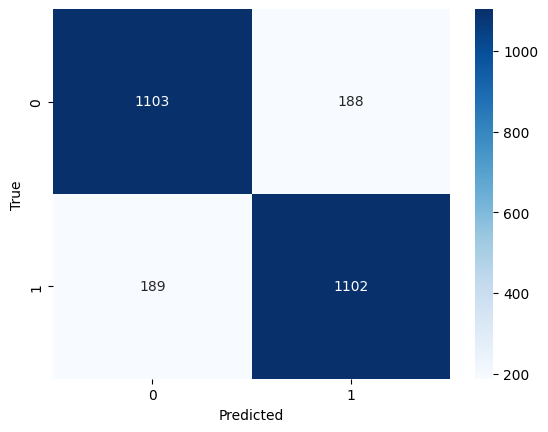

In [100]:
#@title Matriz de confusão
rf_cm = confusion_matrix(y_test, rf_preds)
plot_conf_matrix(rf_cm)

AUC-ROC: 0.8539891556932611


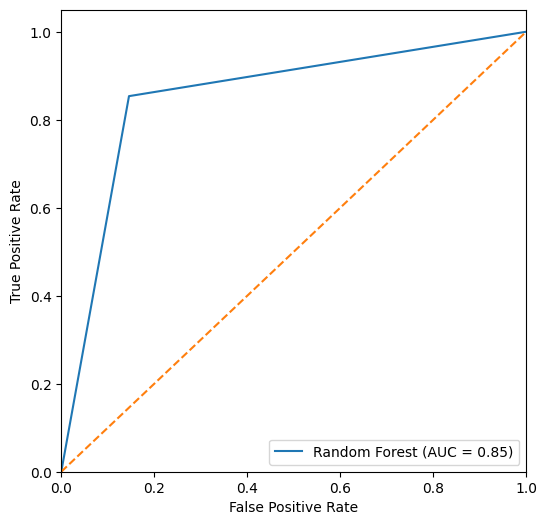

In [101]:
#@title AUC-ROC
rf_auc = roc_auc_score(y_test, rf_preds)
print(f"AUC-ROC: {rf_auc}")
rf_fpr, rf_tpr, _ = roc_curve(y_test, rf_preds)
plot_roc(rf_fpr, rf_tpr, rf_auc, 'Random Forest')

In [102]:
#@title Recall, precision e f-score
rf_recall = recall_score(y_test, rf_preds)
rf_precision = precision_score(y_test, rf_preds)
rf_f1 = f1_score(y_test, rf_preds)
print(f"Recall: {rf_recall}")
print(f"Precision: {rf_precision}")
print(f"F1-score: {rf_f1}")

Recall: 0.8536018590240124
Precision: 0.8542635658914729
F1-score: 0.8539325842696629


# Otimizando classificadores iniciais

## MLP

In [121]:
#@title Otimização do MLP com Optuna

# A função de otimização para o MLP
def objective_mlp(trial):
    """
    Essa função tem o mesmo 'objetivo' da sua versão RF abaixo
    """

    model = Sequential() #modelo sequencial

    n_layers = trial.suggest_int('n_layers', 1, 2)

    #As n layers são adicionadas de acordo com os hiperparametros escolhidos
    for i in range(n_layers):
        n_units = trial.suggest_int(f'n_units_l{i}', 10, 100)
        activation = trial.suggest_categorical(f'activation_l{i}', ['relu', 'tanh', 'sigmoid'])#funções de ativação mais comuns
        model.add(Dense(n_units, activation=activation))

        #adiciona a camada de dropout
        dropout_rate = trial.suggest_float(f'dropout_l{i}', 0.0, 0.5)
        model.add(Dropout(dropout_rate))

    #adiciona a camada de saída
    model.add(Dense(1, activation='sigmoid'))

    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-2, log=True)
    optimizer = Adam(learning_rate=learning_rate)
    loss = trial.suggest_categorical('loss', ['mse', 'binary_crossentropy']) # variando entre mse e cross-entropy

    #compilando o modelo 'treinado'
    model.compile(optimizer=optimizer,
                  loss=loss,
                  metrics=['AUC'])

    early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
    optuna_pruning_callback = optuna.integration.TFKerasPruningCallback(trial, monitor='val_auc')
    history = model.fit(X_train_n, y_train,
              validation_data=(X_val_n, y_val),
              epochs=10000,
              callbacks=[early_stopping, optuna_pruning_callback],
              verbose=0)

    #avaliação do modelo
    val_auc = model.evaluate(X_val_n, y_val, verbose=0)[1]

    return val_auc

#otimização pelo optuna
print("Iniciando a busca pelos hiperparametros do MLP...")
mlp_pruner = optuna.pruners.MedianPruner(n_startup_trials=3, n_warmup_steps=5)
study_mlp = optuna.create_study(direction='maximize', pruner=mlp_pruner)
study_mlp.optimize(objective_mlp, n_trials=10)

print("\n------------------Resultados da Otimização do MLP--------------------------")
print("Melhores hiperparametros encontrados:")
print(study_mlp.best_params)
print("\nMelhor area AUC no conjunto de validação:")
print(study_mlp.best_value)

[I 2025-08-11 05:33:27,775] A new study created in memory with name: no-name-f73023fb-fa45-45b4-acd6-172cadf9309a


Iniciando a busca pelos hiperparametros do MLP...


[I 2025-08-11 05:35:18,501] Trial 0 finished with value: 0.9375890493392944 and parameters: {'n_layers': 2, 'n_units_l0': 62, 'activation_l0': 'sigmoid', 'dropout_l0': 0.00883300641844964, 'n_units_l1': 78, 'activation_l1': 'relu', 'dropout_l1': 0.29026692919908686, 'learning_rate': 0.00016351309910450697, 'loss': 'binary_crossentropy'}. Best is trial 0 with value: 0.9375890493392944.
[I 2025-08-11 05:36:52,341] Trial 1 finished with value: 0.9350017309188843 and parameters: {'n_layers': 1, 'n_units_l0': 84, 'activation_l0': 'relu', 'dropout_l0': 0.3653445612492363, 'learning_rate': 0.00019486666169377256, 'loss': 'mse'}. Best is trial 0 with value: 0.9375890493392944.
[I 2025-08-11 05:37:14,137] Trial 2 finished with value: 0.9298080205917358 and parameters: {'n_layers': 2, 'n_units_l0': 78, 'activation_l0': 'relu', 'dropout_l0': 0.15533000053073426, 'n_units_l1': 27, 'activation_l1': 'tanh', 'dropout_l1': 0.2859673783536025, 'learning_rate': 0.002396643571965111, 'loss': 'mse'}. Best


------------------Resultados da Otimização do MLP--------------------------
Melhores hiperparametros encontrados:
{'n_layers': 2, 'n_units_l0': 62, 'activation_l0': 'sigmoid', 'dropout_l0': 0.00883300641844964, 'n_units_l1': 78, 'activation_l1': 'relu', 'dropout_l1': 0.29026692919908686, 'learning_rate': 0.00016351309910450697, 'loss': 'binary_crossentropy'}

Melhor area AUC no conjunto de validação:
0.9375890493392944


#### Avaliação com melhor modelo

In [122]:
#@title Criando melhor modelo

best_mlp_params = study_mlp.best_params
best_mlp = Sequential()
best_mlp.add(Input(shape=(X_train.shape[1],)))
for i in range(best_mlp_params['n_layers']):
  best_mlp.add(Dense(best_mlp_params[f'n_units_l{i}'], activation=best_mlp_params[f'activation_l{i}']))
  best_mlp.add(Dropout(best_mlp_params[f'dropout_l{i}']))
best_mlp.add(Dense(1, activation='sigmoid'))
best_mlp.compile(optimizer=Adam(learning_rate=best_mlp_params['learning_rate']),
                 loss=best_mlp_params['loss'],
                 metrics=['AUC'])
best_mlp.summary()

Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_59 (Dense)            (None, 62)                2542      
                                                                 
 dropout_32 (Dropout)        (None, 62)                0         
                                                                 
 dense_60 (Dense)            (None, 78)                4914      
                                                                 
 dropout_33 (Dropout)        (None, 78)                0         
                                                                 
 dense_61 (Dense)            (None, 1)                 79        
                                                                 
Total params: 7535 (29.43 KB)
Trainable params: 7535 (29.43 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [123]:
#@title Treinando melhor modelo

best_mlp_early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
best_mlp.fit(X_train_n, y_train,
             validation_data=(X_val_n, y_val),
             epochs=10000,
             callbacks=[best_mlp_early_stopping],
             verbose=1)

Epoch 1/10000
162/162 [==============================] - 2s 6ms/step - loss: 0.6648 - auc: 0.6328 - val_loss: 0.5878 - val_auc: 0.8446
Epoch 2/10000
162/162 [==============================] - 1s 5ms/step - loss: 0.5660 - auc: 0.8032 - val_loss: 0.5151 - val_auc: 0.8585
Epoch 3/10000
162/162 [==============================] - 1s 4ms/step - loss: 0.5075 - auc: 0.8430 - val_loss: 0.4748 - val_auc: 0.8655
Epoch 4/10000
162/162 [==============================] - 1s 3ms/step - loss: 0.4744 - auc: 0.8600 - val_loss: 0.4570 - val_auc: 0.8721
Epoch 5/10000
162/162 [==============================] - 0s 3ms/step - loss: 0.4591 - auc: 0.8676 - val_loss: 0.4437 - val_auc: 0.8777
Epoch 6/10000
162/162 [==============================] - 0s 3ms/step - loss: 0.4441 - auc: 0.8768 - val_loss: 0.4355 - val_auc: 0.8828
Epoch 7/10000
162/162 [==============================] - 0s 3ms/step - loss: 0.4355 - auc: 0.8818 - val_loss: 0.4267 - val_auc: 0.8871
Epoch 8/10000
162/162 [==============================] 

In [124]:
#@title Gerando predições

# Gerar predições
best_mlp_preds = best_mlp.predict(X_test_n).squeeze()
best_mlp_preds_class = np.where(best_mlp_preds >= 0.5, 1, 0)
best_mlp_preds_scores = np.concatenate([1 - best_mlp_preds.reshape(-1, 1), best_mlp_preds.reshape(-1, 1)], axis=1)
best_mlp_preds.shape

81/81 [==============================] - 0s 1ms/step


(2582,)

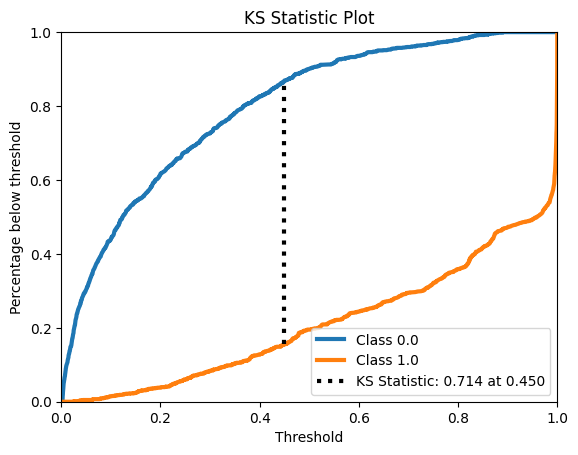

In [125]:
#@title Teste Kolmogorov-Smirnov

best_mlp_ks = plot_ks(y_test, best_mlp_preds_scores)

In [126]:
#@title MSE

best_mlp_mse = mean_squared_error(y_test, best_mlp_preds_class)
print(f"MSE: {best_mlp_mse}")

MSE: 0.1475600302219391


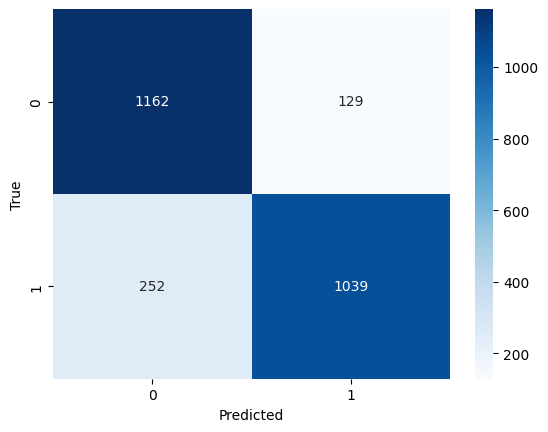

In [127]:
#@title Matriz de confusão

best_mlp_cm = confusion_matrix(y_test, best_mlp_preds_class)
plot_conf_matrix(best_mlp_cm)

AUC-ROC: 0.937142140577591


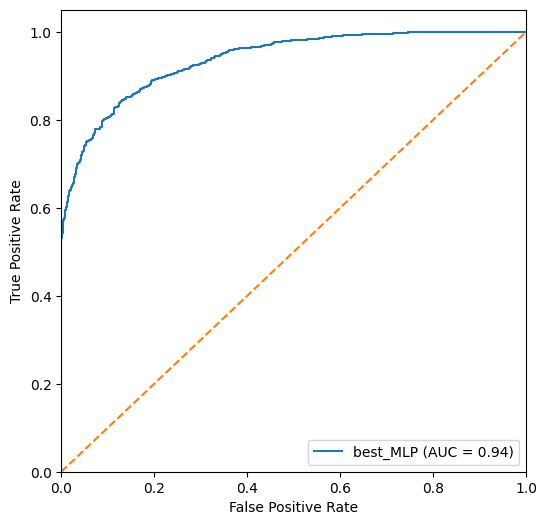

In [128]:
#@title AUC-ROC

best_mlp_auc = roc_auc_score(y_test, best_mlp_preds)
print(f"AUC-ROC: {best_mlp_auc}")
best_mlp_fpr, best_mlp_tpr, _ = roc_curve(y_test, best_mlp_preds)
plot_roc(best_mlp_fpr, best_mlp_tpr, best_mlp_auc, 'best_MLP')

In [129]:
#@title Recall, precision e f-score

best_mlp_recall = recall_score(y_test, best_mlp_preds_class)
best_mlp_precision = precision_score(y_test, best_mlp_preds_class)
best_mlp_f1 = f1_score(y_test, best_mlp_preds_class)
print(f"Recall: {best_mlp_recall}")
print(f"Precision: {best_mlp_precision}")
print(f"F1-score: {best_mlp_f1}")

Recall: 0.8048024786986832
Precision: 0.889554794520548
F1-score: 0.8450589670597805


## Random Forest

In [130]:
#@title Otimização do Random Forest com Optuna

# A função de otimização de hiperparâmetros.
def objective_rf(trial):
    """
    Eu uso os dados de X e y definidos anteriormente. Para achar os melhores hiperparametros usando essa função objective_rf
    """
    # Sugere os hiperparâmetros, conforme a especificação do projeto.
    n_estimators = trial.suggest_int('n_estimators', 50, 500)
    max_depth = trial.suggest_int('max_depth', 2, 32)
    max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2', None])
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)

    #Aqui pega os melhores parametros achados e utiliza para criar um modelo com esse parametros
    model = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        max_features=max_features,
        min_samples_leaf=min_samples_leaf,
        random_state=42
    )


    model.fit(X_train_n, y_train)


    y_pred = model.predict_proba(X_val_n)[:, 1]
    auc_score = roc_auc_score(y_val, y_pred)

    return auc_score

# Cria o estudo do Optuna e executa a otimização
print("Iniciando a busca pelos hiperparametros do modelo Random Forest...")
study_rf = optuna.create_study(direction='maximize')
study_rf.optimize(objective_rf, n_trials=20)

print("\n--- Resultados da Otimização do Random Forest ---")
print("Melhores hiperparametros encontrados:")
print(study_rf.best_params)
print("\nMelhor Area AUC no conjunto de validação:")
print(study_rf.best_value)

[I 2025-08-11 05:42:07,109] A new study created in memory with name: no-name-e1545ef4-c965-4248-9b58-fd5574f3e29c


Iniciando a busca pelos hiperparametros do modelo Random Forest...


[I 2025-08-11 05:42:08,427] Trial 0 finished with value: 0.9261998690997304 and parameters: {'n_estimators': 259, 'max_depth': 14, 'max_features': 'log2', 'min_samples_leaf': 3}. Best is trial 0 with value: 0.9261998690997304.
[I 2025-08-11 05:42:14,989] Trial 1 finished with value: 0.9236878448891851 and parameters: {'n_estimators': 287, 'max_depth': 22, 'max_features': None, 'min_samples_leaf': 5}. Best is trial 0 with value: 0.9261998690997304.
[I 2025-08-11 05:42:16,512] Trial 2 finished with value: 0.9226217282438347 and parameters: {'n_estimators': 307, 'max_depth': 27, 'max_features': 'sqrt', 'min_samples_leaf': 7}. Best is trial 0 with value: 0.9261998690997304.
[I 2025-08-11 05:42:17,200] Trial 3 finished with value: 0.9235899699169564 and parameters: {'n_estimators': 140, 'max_depth': 24, 'max_features': 'log2', 'min_samples_leaf': 5}. Best is trial 0 with value: 0.9261998690997304.
[I 2025-08-11 05:42:19,686] Trial 4 finished with value: 0.9307477527786285 and parameters: {'


--- Resultados da Otimização do Random Forest ---
Melhores hiperparametros encontrados:
{'n_estimators': 417, 'max_depth': 16, 'max_features': 'log2', 'min_samples_leaf': 1}

Melhor Area AUC no conjunto de validação:
0.9307477527786285


### Avaliação com o melhor modelo

In [131]:
#@title Criando melhor modelo

best_rf_params = study_rf.best_params
best_rf = RandomForestClassifier(
    n_estimators=best_rf_params['n_estimators'],
    max_depth=best_rf_params['max_depth'],
    max_features=best_rf_params['max_features'],
    min_samples_leaf=best_rf_params['min_samples_leaf'],
    random_state=42
)
best_rf

RandomForestClassifier(max_depth=16, max_features='log2', n_estimators=417,
                       random_state=42)

In [132]:
#@title Treinando melhor modelo

best_rf.fit(X_train_n, y_train)

RandomForestClassifier(max_depth=16, max_features='log2', n_estimators=417,
                       random_state=42)

In [133]:
#@title Gerando predições

best_rf_preds = best_rf.predict(X_test_n)
best_rf_preds_0 = 1 - best_rf_preds
best_rf_preds_scores = np.concatenate([best_rf_preds_0.reshape(-1, 1), best_rf_preds.reshape(-1, 1)], axis=1)
print(f"Predições: {best_rf_preds.shape}")

Predições: (2582,)


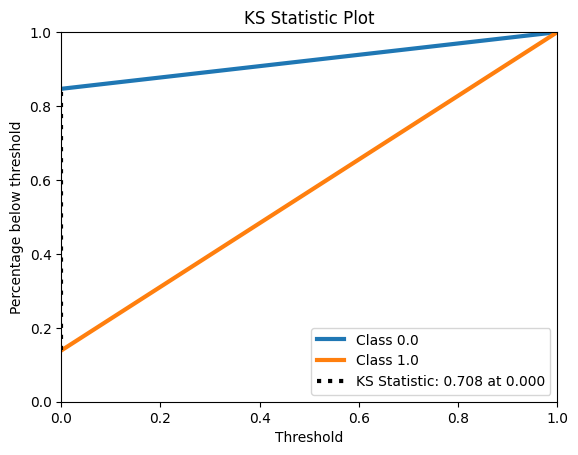

In [134]:
#@title Teste Kolmogorov-Smirnov

best_rf_ks = plot_ks(y_test, best_rf_preds_scores)

In [135]:
#@title MSE

best_rf_mse = mean_squared_error(y_test, best_rf_preds)
print(f"MSE: {best_rf_mse}")

MSE: 0.1460108458995819


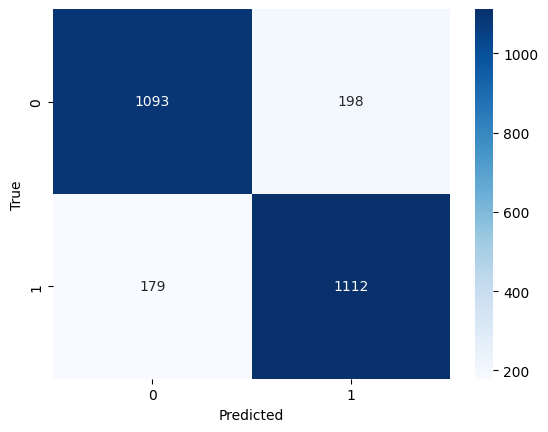

In [136]:
#@title Matriz de confusão

best_rf_cm = confusion_matrix(y_test, best_rf_preds)
plot_conf_matrix(best_rf_cm)

AUC-ROC: 0.8539891556932612


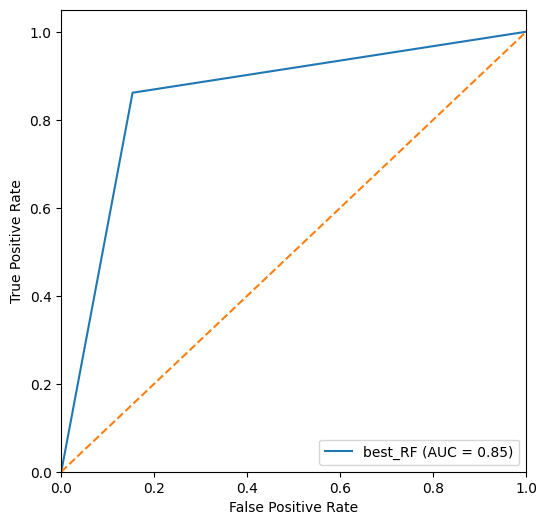

In [137]:
#@title AUC-ROC

best_rf_auc = roc_auc_score(y_test, best_rf_preds)
print(f"AUC-ROC: {best_rf_auc}")
best_rf_fpr, best_rf_tpr, _ = roc_curve(y_test, best_rf_preds)
plot_roc(best_rf_fpr, best_rf_tpr, best_rf_auc, 'best_RF')

In [138]:
#@title Recall, precision e f-score

best_rf_recall = recall_score(y_test, best_rf_preds)
best_rf_precision = precision_score(y_test, best_rf_preds)
best_rf_f1 = f1_score(y_test, best_rf_preds)
print(f"Recall: {best_rf_recall}")
print(f"Precision: {best_rf_precision}")
print(f"F1-score: {best_rf_f1}")

Recall: 0.8613477924089853
Precision: 0.8488549618320611
F1-score: 0.8550557477893118


# Executando mais classificadores

## STab

In [139]:
#@title Preparação

# Converter para tensores
X_train_t = torch.tensor(X_train_n.astype(np.float32)).to('cuda')
X_val_t = torch.tensor(X_val_n.astype(np.float32)).to('cuda')
X_test_t = torch.tensor(X_test_n.astype(np.float32)).to('cuda')
y_train_t = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1).to('cuda')
y_val_t = torch.tensor(y_val, dtype=torch.float32).unsqueeze(1).to('cuda')
y_test_t = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1).to('cuda')

### Primeira execução

In [140]:
#@title Definição do modelo

# Definir o modelo STAB
Or_model = mainmodel.MainModel(
    categories        = (),   # Sem features categóricas após encoding
    num_continuous    = 39,   # 39 features numéricas
    dim               = 16,
    dim_out           = 1,    # 1 classe de saída
    depth             = 2,
    heads             = 4,
    attn_dropout      = 0.1,
    ff_dropout        = 0.1,
    U                 = 2,
    cases             = 8,
)

# Criar wrapper Num_Cat
stab_wrapper = Num_Cat(Or_model, num_number=39, classes=1, Sample_size=16)

# Converter para keras4torch
stab = keras4torch.Model(stab_wrapper).build([39]).to('cuda')

# Configurar otimizador e compilar
stab_optimizer = torch.optim.AdamW(stab.parameters(), lr=0.001, weight_decay=0.0001)
stab.compile(optimizer=stab_optimizer, loss=torch.nn.BCEWithLogitsLoss(), metrics=['roc_auc'])
stab.summary()

Layer (type:depth-idx)                   Output Shape              Param #
├─MainModel: 1-1                         [8, 1]                    --
|    └─NumericalEmbedder: 2-1            [8, 39, 16]               --
|    |    └─LWTA: 3-1                    [8, 39, 8]                1
|    └─Transformer: 2-2                  [8, 40, 16]               --
|    └─Sequential: 2-3                   [8, 1]                    --
|    |    └─Dropout: 3-2                 [8, 16]                   --
|    |    └─LayerNorm: 3-3               [8, 16]                   32
|    |    └─Linear: 3-4                  [8, 1]                    17
Total params: 50
Trainable params: 50
Non-trainable params: 0
Total mult-adds (M): 0.06


In [141]:
#@title Treinamento inicial

stab_early_stopping = keras4torch.callbacks.EarlyStopping(monitor='val_loss', patience=15, verbose=0)

# Treinamento
stab.fit([X_train_t], y_train_t,
          epochs=10000, batch_size=32,
          validation_data=([X_val_t], y_val_t),
          callbacks=[stab_early_stopping],
          verbose=1)



Train on 5163 samples, validate on 2581 samples:
Epoch 1/10000
162/162 - 28s - loss: 0.5310 - auc: 0.8166 - val_loss: 0.4636 - val_auc: 0.8785 - lr: 1e-03
Epoch 2/10000
162/162 - 26s - loss: 0.4683 - auc: 0.8671 - val_loss: 0.4503 - val_auc: 0.8906 - lr: 1e-03
Epoch 3/10000
162/162 - 27s - loss: 0.4458 - auc: 0.8807 - val_loss: 0.4310 - val_auc: 0.8987 - lr: 1e-03
Epoch 4/10000
162/162 - 27s - loss: 0.4247 - auc: 0.8910 - val_loss: 0.4192 - val_auc: 0.9040 - lr: 1e-03
Epoch 5/10000
162/162 - 27s - loss: 0.4208 - auc: 0.8942 - val_loss: 0.4048 - val_auc: 0.9092 - lr: 1e-03
Epoch 6/10000
162/162 - 27s - loss: 0.4053 - auc: 0.9006 - val_loss: 0.3835 - val_auc: 0.9160 - lr: 1e-03
Epoch 7/10000
162/162 - 27s - loss: 0.3904 - auc: 0.9096 - val_loss: 0.4032 - val_auc: 0.9181 - lr: 1e-03
Epoch 8/10000
162/162 - 27s - loss: 0.3837 - auc: 0.9128 - val_loss: 0.3691 - val_auc: 0.9211 - lr: 1e-03
Epoch 9/10000
162/162 - 28s - loss: 0.3763 - auc: 0.9131 - val_loss: 0.3649 - val_auc: 0.9235 - lr: 1e-

,loss,auc,val_loss,val_auc,lr
1,0.530962,0.816627,0.463570,0.878534,0.001
2,0.468298,0.867137,0.450305,0.890642,0.001
3,0.445836,0.880703,0.431046,0.898698,0.001
4,0.424730,0.890994,0.419186,0.903993,0.001
5,0.420760,0.894206,0.404763,0.909165,0.001
...,...,...,...,...,...
66,0.309124,0.940143,0.331296,0.932281,0.001
67,0.312597,0.940644,0.323007,0.934362,0.001
68,0.310183,0.940312,0.325593,0.933420,0.001
69,0.308486,0.939997,0.336627,0.934019,0.001


#### Avaliação inicial

In [142]:
#@title Gerando predições

# Gerar predições
stab_preds = stab.predict([X_test_t]).squeeze()
stab_preds_class = np.where(stab_preds >= 0.5, 1, 0)
stab_preds_scores = np.concatenate([1 - stab_preds.reshape(-1, 1), stab_preds.reshape(-1, 1)], axis=1)
stab_preds.shape

(2582,)

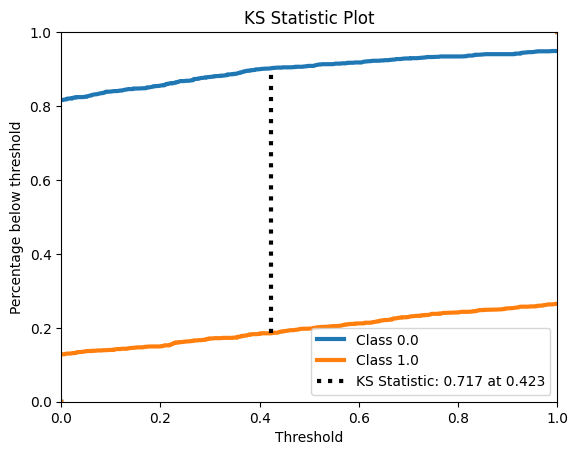

In [143]:
#@title Teste Kolmogorov-Smirnov

stab_ks = plot_ks(y_test, stab_preds_scores)

In [144]:
#@title MSE

stab_mse = mean_squared_error(y_test, stab_preds_class)
print(f"MSE: {stab_mse}")

MSE: 0.14446166157722473


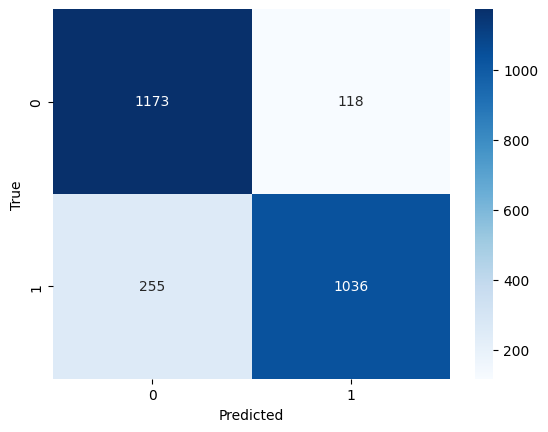

In [145]:
#@title Matriz de confusão

stab_cm = confusion_matrix(y_test, stab_preds_class)
plot_conf_matrix(stab_cm)

AUC-ROC: 0.9363279475796507


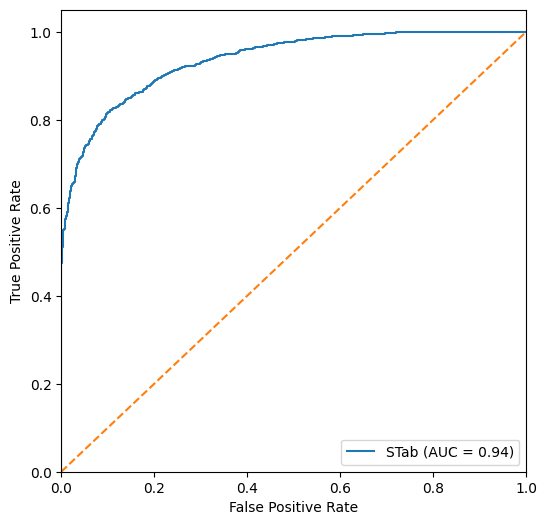

In [146]:
#@title AUC-ROC

stab_auc = roc_auc_score(y_test, stab_preds)
print(f"AUC-ROC: {stab_auc}")
stab_fpr, stab_tpr, _ = roc_curve(y_test, stab_preds)
plot_roc(stab_fpr, stab_tpr, stab_auc, 'STab')

In [147]:
#@title Recall, precision e f-score

stab_recall = recall_score(y_test, stab_preds_class)
stab_precision = precision_score(y_test, stab_preds_class)
stab_f1 = f1_score(y_test, stab_preds_class)
print(f"Recall: {stab_recall}")
print(f"Precision: {stab_precision}")
print(f"F1-score: {stab_f1}")

Recall: 0.8024786986831913
Precision: 0.8977469670710572
F1-score: 0.847443762781186


### Otimização com optuna

In [150]:
#@title Otimização do STab com Optuna

# preparação dos dados
X_train_t = torch.tensor(X_train_n.astype(np.float32)).to('cuda')
y_train_t = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1).to('cuda')
X_val_t = torch.tensor(X_val_n.astype(np.float32)).to('cuda')
y_val_t = torch.tensor(y_val, dtype=torch.float32).unsqueeze(1).to('cuda')
X_test_t = torch.tensor(X_test_n.astype(np.float32)).to('cuda')
y_test_t = torch.tensor(y_test,  dtype=torch.float32).unsqueeze(1).to('cuda')

# A função de otimização de hiperparâmetros.
def objective_stab(trial):
    # Sugere os hiperparâmetros, conforme a especificação do projeto.
    dim = trial.suggest_categorical('dim', [8, 16, 32])
    depth = trial.suggest_int('depth', 2, 4)
    heads = trial.suggest_categorical('heads', [2, 4])
    attn_dropout = trial.suggest_float('attn_dropout', 0.1, 0.5)
    ff_dropout = trial.suggest_float('ff_dropout', 0.1, 0.5)
    U = trial.suggest_categorical('U', [2, 4])
    cases = trial.suggest_categorical('cases', [4, 8])
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-2, log=True)
    weight_decay = trial.suggest_float('weight_decay', 1e-5, 1e-2, log=True)
    batch_size = trial.suggest_categorical('batch_size', [32, 64, 128])
    sample_size = trial.suggest_categorical('sample_size', [8, 16, 32])

    #Aqui pega os melhores parametros achados e utiliza para criar um modelo com esse parametros
    Or_model = mainmodel.MainModel(
        categories        = (),
        num_continuous    = 39,
        dim               = dim,
        dim_out           = 1,
        depth             = depth,
        heads             = heads,
        attn_dropout      = attn_dropout,
        ff_dropout        = ff_dropout,
        U                 = U,
        cases             = cases,
    )

    model_wrapper = Num_Cat(Or_model, num_number=39, classes=1, Sample_size=sample_size)
    model = keras4torch.Model(model_wrapper).build([39]).to('cuda')
    model_optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    model.compile(optimizer=stab_optimizer, loss=torch.nn.BCEWithLogitsLoss(), metrics=['roc_auc'])

    model_early_stopping = keras4torch.callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=0)
    optuna_pruner_callback = OptunaPruningCallback(trial, monitor='val_roc_auc')
    model.fit([X_train_t], y_train_t,
              epochs=10000, batch_size=batch_size,
              validation_data=([X_val_t], y_val_t),
              callbacks=[model_early_stopping, optuna_pruner_callback],
              verbose=0)

    y_pred = model.predict([X_val_t]).squeeze()
    auc_score = roc_auc_score(y_val, y_pred)

    return auc_score

# Cria o estudo do Optuna e executa a otimização
print("Iniciando a busca pelos hiperparametros do modelo STab...")
stab_pruner = optuna.pruners.MedianPruner(n_startup_trials=3, n_warmup_steps=5)
study_stab = optuna.create_study(direction='maximize', pruner=stab_pruner)
study_stab.optimize(objective_stab, n_trials=10)

print("\n--- Resultados da Otimização do STab ---")
print("Melhores hiperparametros encontrados:")
print(study_stab.best_params)
print("\nMelhor Area AUC no conjunto de validação:")
print(study_stab.best_value)

[I 2025-08-11 06:37:33,514] A new study created in memory with name: no-name-6d26088c-9556-481b-a6d6-17db1f8fef69


Iniciando a busca pelos hiperparametros do modelo STab...


[I 2025-08-11 06:43:42,274] Trial 0 finished with value: 0.6233798089336431 and parameters: {'dim': 8, 'depth': 3, 'heads': 2, 'attn_dropout': 0.412001197069532, 'ff_dropout': 0.2359221124302116, 'U': 4, 'cases': 8, 'learning_rate': 0.0005046855829768766, 'weight_decay': 0.002711650218025983, 'batch_size': 64, 'sample_size': 16}. Best is trial 0 with value: 0.6233798089336431.
[I 2025-08-11 06:53:18,902] Trial 1 finished with value: 0.6218960723914518 and parameters: {'dim': 32, 'depth': 3, 'heads': 2, 'attn_dropout': 0.4381145387583747, 'ff_dropout': 0.20413162162212872, 'U': 2, 'cases': 8, 'learning_rate': 0.000394041790998935, 'weight_decay': 2.688781346339561e-05, 'batch_size': 64, 'sample_size': 32}. Best is trial 0 with value: 0.6233798089336431.
[I 2025-08-11 07:00:25,265] Trial 2 finished with value: 0.5341799818661095 and parameters: {'dim': 32, 'depth': 4, 'heads': 2, 'attn_dropout': 0.1667314443449563, 'ff_dropout': 0.29759482697018513, 'U': 4, 'cases': 8, 'learning_rate': 2


--- Resultados da Otimização do STab ---
Melhores hiperparametros encontrados:
{'dim': 8, 'depth': 3, 'heads': 2, 'attn_dropout': 0.412001197069532, 'ff_dropout': 0.2359221124302116, 'U': 4, 'cases': 8, 'learning_rate': 0.0005046855829768766, 'weight_decay': 0.002711650218025983, 'batch_size': 64, 'sample_size': 16}

Melhor Area AUC no conjunto de validação:
0.6233798089336431


#### Avaliação com melhor modelo

In [151]:
#@title Criando melhor modelo

best_Or_model = mainmodel.MainModel(
    categories        = (),
    num_continuous    = 39,
    dim               = study_stab.best_params['dim'],
    dim_out           = 1,
    depth             = study_stab.best_params['depth'],
    heads             = study_stab.best_params['heads'],
    attn_dropout      = study_stab.best_params['attn_dropout'],
    ff_dropout        = study_stab.best_params['ff_dropout'],
    U                 = study_stab.best_params['U'],
    cases             = study_stab.best_params['cases']
)

best_stab_wrapper = Num_Cat(best_Or_model, num_number=39, classes=1, Sample_size=study_stab.best_params['sample_size'])
best_stab = keras4torch.Model(best_stab_wrapper).build([39]).to('cuda')

best_stab_optimizer = torch.optim.AdamW(
    best_stab.parameters(),
    lr=study_stab.best_params['learning_rate'],
    weight_decay=study_stab.best_params['weight_decay'])

best_stab.compile(optimizer=best_stab_optimizer, loss=torch.nn.BCEWithLogitsLoss(), metrics=['roc_auc'])
best_stab.summary()

Layer (type:depth-idx)                   Output Shape              Param #
├─MainModel: 1-1                         [8, 1]                    --
|    └─NumericalEmbedder: 2-1            [8, 39, 8]                --
|    |    └─LWTA: 3-1                    [8, 39, 8]                1
|    └─Transformer: 2-2                  [8, 40, 8]                --
|    └─Sequential: 2-3                   [8, 1]                    --
|    |    └─Dropout: 3-2                 [8, 8]                    --
|    |    └─LayerNorm: 3-3               [8, 8]                    16
|    |    └─Linear: 3-4                  [8, 1]                    9
Total params: 26
Trainable params: 26
Non-trainable params: 0
Total mult-adds (M): 0.03


In [152]:
#@title Treinando melhor modelo

best_stab_early_stopping = keras4torch.callbacks.EarlyStopping(monitor='val_loss', patience=15, verbose=0)
best_stab_history = best_stab.fit([X_train_t], y_train_t,
                      epochs=10000, batch_size=study_stab.best_params['batch_size'],
                      validation_data=([X_val_t], y_val_t),
                      callbacks=[best_stab_early_stopping],
                      verbose=1)

Train on 5163 samples, validate on 2581 samples:
Epoch 1/10000
81/81 - 19s - loss: 0.6948 - auc: 0.5904 - val_loss: 0.6057 - val_auc: 0.8326 - lr: 5e-04
Epoch 2/10000
81/81 - 19s - loss: 0.5942 - auc: 0.7493 - val_loss: 0.5303 - val_auc: 0.8609 - lr: 5e-04
Epoch 3/10000
81/81 - 20s - loss: 0.5428 - auc: 0.7996 - val_loss: 0.4994 - val_auc: 0.8682 - lr: 5e-04
Epoch 4/10000
81/81 - 19s - loss: 0.5222 - auc: 0.8173 - val_loss: 0.4767 - val_auc: 0.8729 - lr: 5e-04
Epoch 5/10000
81/81 - 20s - loss: 0.5069 - auc: 0.8288 - val_loss: 0.4712 - val_auc: 0.8792 - lr: 5e-04
Epoch 6/10000
81/81 - 19s - loss: 0.4994 - auc: 0.8353 - val_loss: 0.4628 - val_auc: 0.8802 - lr: 5e-04
Epoch 7/10000
81/81 - 19s - loss: 0.4893 - auc: 0.8431 - val_loss: 0.4557 - val_auc: 0.8853 - lr: 5e-04
Epoch 8/10000
81/81 - 19s - loss: 0.4805 - auc: 0.8511 - val_loss: 0.4501 - val_auc: 0.8891 - lr: 5e-04
Epoch 9/10000
81/81 - 19s - loss: 0.4830 - auc: 0.8512 - val_loss: 0.4483 - val_auc: 0.8892 - lr: 5e-04
Epoch 10/10000


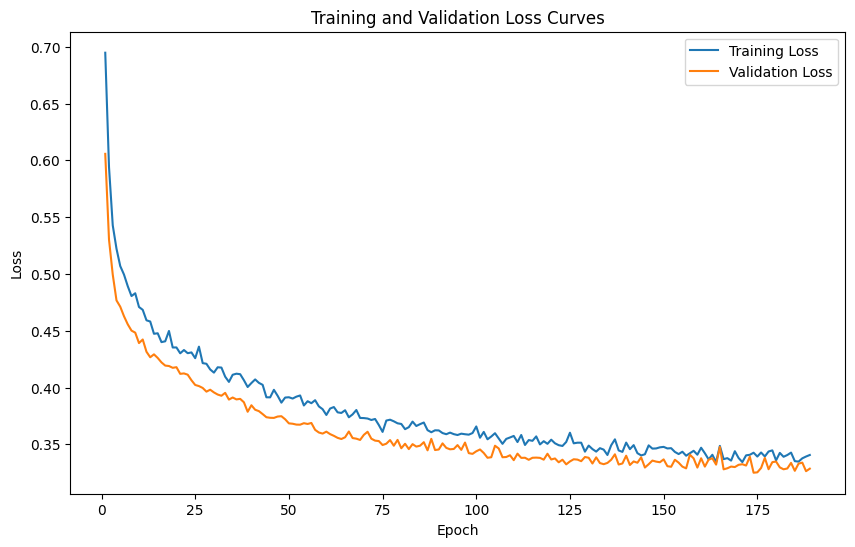

In [156]:
#@title Curvas de aprendizado

best_stab_train_loss = best_stab_history['loss']
best_stab_val_loss = best_stab_history['val_loss']

plt.figure(figsize=(10, 6))
plt.plot(best_stab_train_loss, label='Training Loss')
plt.plot(best_stab_val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Curves')
plt.legend()
plt.show()

In [157]:
#@title Gerando predições

# Gerar predições
best_stab_preds = best_stab.predict([X_test_t]).squeeze()
best_stab_preds_class = np.where(best_stab_preds >= 0.5, 1, 0)
best_stab_preds_scores = np.concatenate([1 - best_stab_preds.reshape(-1, 1), best_stab_preds.reshape(-1, 1)], axis=1)
best_stab_preds.shape

(2582,)

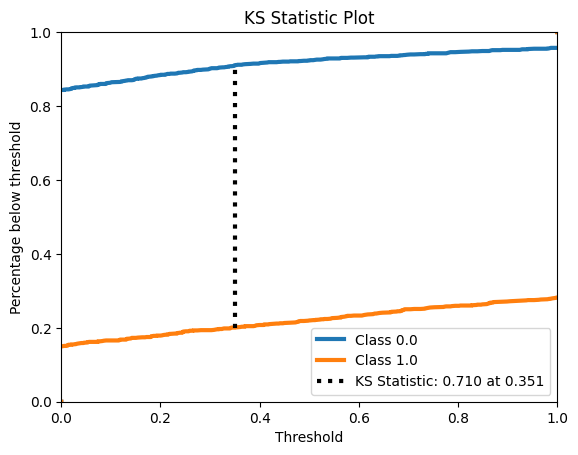

In [158]:
#@title Teste Kolmogorov-Smirnov

best_stab_ks = plot_ks(y_test, best_stab_preds_scores)

In [159]:
#@title MSE

best_stab_mse = mean_squared_error(y_test, best_stab_preds_class)
print(f"MSE: {best_stab_mse}")

MSE: 0.14794732630252838


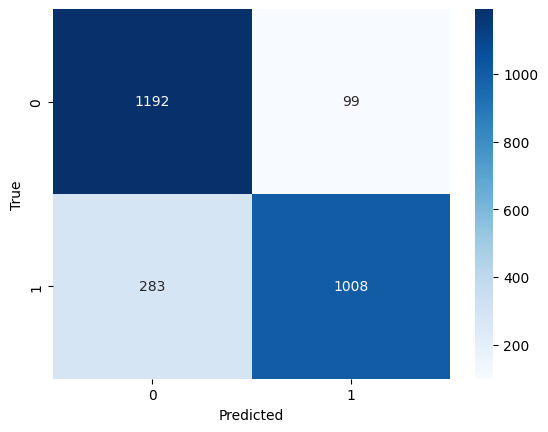

In [160]:
#@title Matriz de confusão

best_stab_cm = confusion_matrix(y_test, best_stab_preds_class)
plot_conf_matrix(best_stab_cm)

AUC-ROC: 0.935193957331967


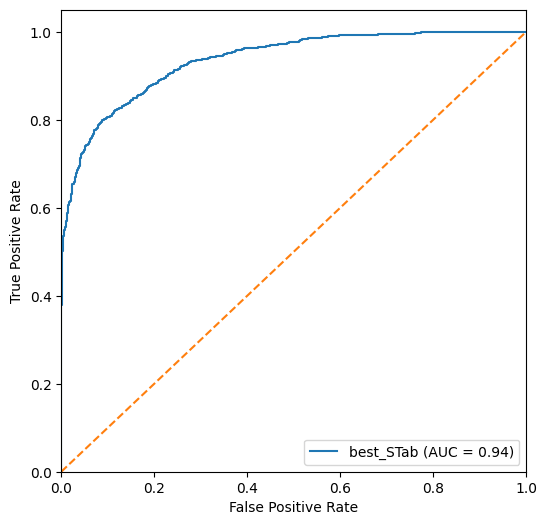

In [161]:
#@title AUC-ROC

best_stab_auc = roc_auc_score(y_test, best_stab_preds)
print(f"AUC-ROC: {best_stab_auc}")
best_stab_fpr, best_stab_tpr, _ = roc_curve(y_test, best_stab_preds)
plot_roc(best_stab_fpr, best_stab_tpr, best_stab_auc, 'best_STab')

In [162]:
#@title Recall, precision e f-score

best_stab_recall = recall_score(y_test, best_stab_preds_class)
best_stab_precision = precision_score(y_test, best_stab_preds_class)
best_stab_f1 = f1_score(y_test, best_stab_preds_class)
print(f"Recall: {best_stab_recall}")
print(f"Precision: {best_stab_precision}")
print(f"F1-score: {best_stab_f1}")

Recall: 0.7807900852052673
Precision: 0.9105691056910569
F1-score: 0.8407005838198499


## TabPFN2 Transformer

### Primeira execução

In [163]:
#@title Definição do modelo

tabpfn = TabPFNClassifier(
    n_estimators=100,
    softmax_temperature=0.1,
    balance_probabilities=True,
    random_state=42
)
tabpfn

TabPFNClassifier(balance_probabilities=True, n_estimators=100, random_state=42,
                 softmax_temperature=0.1)

In [164]:
#@title Treinamento inicial

tabpfn.fit(X_train_n, y_train)

TabPFNClassifier(balance_probabilities=True, n_estimators=100, random_state=42,
                 softmax_temperature=0.1)

#### Avaliação inicial

In [165]:
#@title Gerando predições

tabpfn_preds = tabpfn.predict_proba(X_test_n)[:, 1]
tabpfn_preds_class = np.where(tabpfn_preds >= 0.5, 1, 0)
tabpfn_preds_scores = np.concatenate([1 - tabpfn_preds.reshape(-1, 1), tabpfn_preds.reshape(-1, 1)], axis=1)
tabpfn_preds.shape

(2582,)

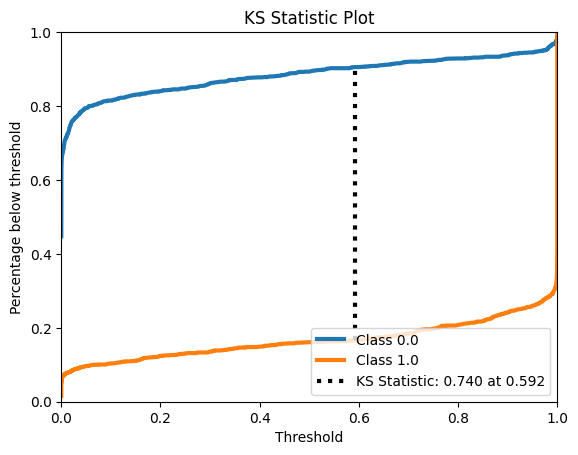

In [166]:
#@title Teste Kolmogorov-Smirnov

tabpfn_ks = plot_ks(y_test, tabpfn_preds_scores)

In [167]:
#@title MSE

tabpfn_mse = mean_squared_error(y_test, tabpfn_preds_class)
print(f"MSE: {tabpfn_mse}")

MSE: 0.1336173564195633


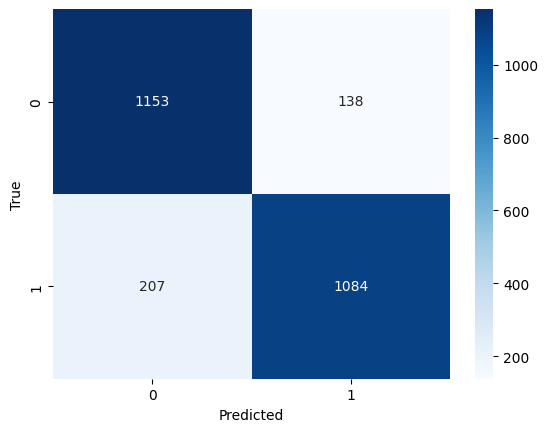

In [168]:
#@title Matriz de confusão

tabpfn_cm = confusion_matrix(y_test, tabpfn_preds_class)
plot_conf_matrix(tabpfn_cm)

AUC-ROC: 0.9371958401157752


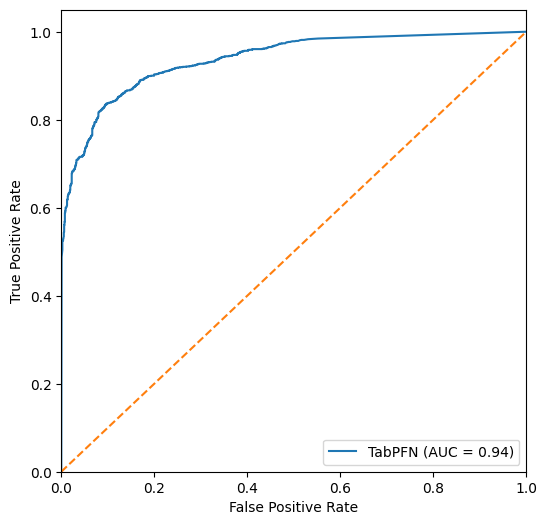

In [169]:
#@title AUC-ROC

tabpfn_auc = roc_auc_score(y_test, tabpfn_preds)
print(f"AUC-ROC: {tabpfn_auc}")
tabpfn_fpr, tabpfn_tpr, _ = roc_curve(y_test, tabpfn_preds)
plot_roc(tabpfn_fpr, tabpfn_tpr, tabpfn_auc, 'TabPFN')

In [170]:
#@title Recall, precision e f-score

tabpfn_recall = recall_score(y_test, tabpfn_preds_class)
tabpfn_precision = precision_score(y_test, tabpfn_preds_class)
tabpfn_f1 = f1_score(y_test, tabpfn_preds_class)
print(f"Recall: {tabpfn_recall}")
print(f"Precision: {tabpfn_precision}")
print(f"F1-score: {tabpfn_f1}")

Recall: 0.8396591789310612
Precision: 0.8870703764320785
F1-score: 0.8627138877835256


### Otimização com optuna

In [171]:
#@title Otimização do tabpfn com optuna

def objective_tabpfn(trial):
    n_estimators = trial.suggest_int("n_estimators", 5, 60)
    softmax_temperature = trial.suggest_float("softmax_temperature", 0.3, 3.0, step=0.1)
    balance_probabilities = trial.suggest_categorical("balance_probabilities", [True, False])
    batch_size = trial.suggest_categorical('batch_size', [32, 64, 128])

    tabpfn = TabPFNClassifier(
        n_estimators=n_estimators,
        softmax_temperature=softmax_temperature,
        balance_probabilities=balance_probabilities,
        random_state=42
    )

    tabpfn.fit(X_train_n, y_train)

    y_pred_proba = tabpfn.predict_proba(X_val_n)[:, 1]
    auc_score = roc_auc_score(y_val, y_pred_proba)

    return auc_score

# Cria o estudo do Optuna e executa a otimização
print("Iniciando a busca pelos hiperparametros do modelo tabpfn...")
study_tabpfn = optuna.create_study(direction="maximize")
study_tabpfn.optimize(objective_tabpfn, n_trials=10)

print("\n--- Resultados da Otimização do tabpfn ---")
print("Melhores hiperparametros encontrados:")
print(study_tabpfn.best_params)
print("\nMelhor Area AUC no conjunto de validação:")
print(study_tabpfn.best_value)

[I 2025-08-11 09:00:13,566] A new study created in memory with name: no-name-94fce519-4f80-43da-b2b9-82b7429793ad


Iniciando a busca pelos hiperparametros do modelo tabpfn...


[I 2025-08-11 09:00:52,961] Trial 0 finished with value: 0.9398071923093091 and parameters: {'n_estimators': 21, 'softmax_temperature': 1.8, 'balance_probabilities': False, 'batch_size': 32}. Best is trial 0 with value: 0.9398071923093091.
[I 2025-08-11 09:02:37,890] Trial 1 finished with value: 0.9396285554734927 and parameters: {'n_estimators': 56, 'softmax_temperature': 0.8, 'balance_probabilities': True, 'batch_size': 128}. Best is trial 0 with value: 0.9398071923093091.
[I 2025-08-11 09:04:20,399] Trial 2 finished with value: 0.9387644936020991 and parameters: {'n_estimators': 55, 'softmax_temperature': 0.3, 'balance_probabilities': True, 'batch_size': 128}. Best is trial 0 with value: 0.9398071923093091.
[I 2025-08-11 09:05:12,999] Trial 3 finished with value: 0.9396792943394641 and parameters: {'n_estimators': 28, 'softmax_temperature': 1.7000000000000002, 'balance_probabilities': True, 'batch_size': 64}. Best is trial 0 with value: 0.9398071923093091.
[I 2025-08-11 09:06:19,885


--- Resultados da Otimização do tabpfn ---
Melhores hiperparametros encontrados:
{'n_estimators': 25, 'softmax_temperature': 1.5000000000000002, 'balance_probabilities': False, 'batch_size': 32}

Melhor Area AUC no conjunto de validação:
0.9400671914686649


#### Avaliação com melhor modelo

In [172]:
#@title Criando melhor modelo

best_tabpfn = TabPFNClassifier(
    n_estimators=study_tabpfn.best_params['n_estimators'],
    softmax_temperature=study_tabpfn.best_params['softmax_temperature'],
    balance_probabilities=study_tabpfn.best_params['balance_probabilities'],
    random_state=42
)
best_tabpfn

TabPFNClassifier(n_estimators=25, random_state=42,
                 softmax_temperature=1.5000000000000002)

In [173]:
#@title Treinando melhor modelo

best_tabpfn_history = best_tabpfn.fit(X_train_n, y_train)

In [175]:
#@title Gerando predições

# Gerar predições
best_tabpfn_preds = best_tabpfn.predict_proba(X_test_n)[:, 1]
best_tabpfn_preds_class = np.where(best_tabpfn_preds >= 0.5, 1, 0)
best_tabpfn_preds_scores = np.concatenate([1 - best_tabpfn_preds.reshape(-1, 1), best_tabpfn_preds.reshape(-1, 1)], axis=1)
best_tabpfn_preds.shape

(2582,)

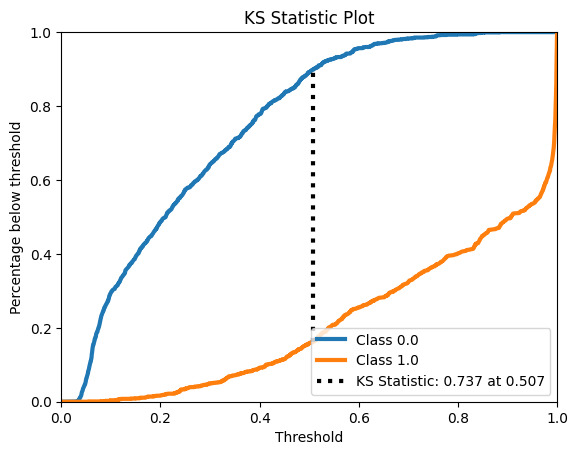

In [176]:
#@title Teste Kolmogorov-Smirnov

best_tabpfn_ks = plot_ks(y_test, best_tabpfn_preds_scores)

In [177]:
#@title MSE

best_tabpfn_mse = mean_squared_error(y_test, best_tabpfn_preds_class)
print(f"MSE: {best_tabpfn_mse}")

MSE: 0.133230060338974


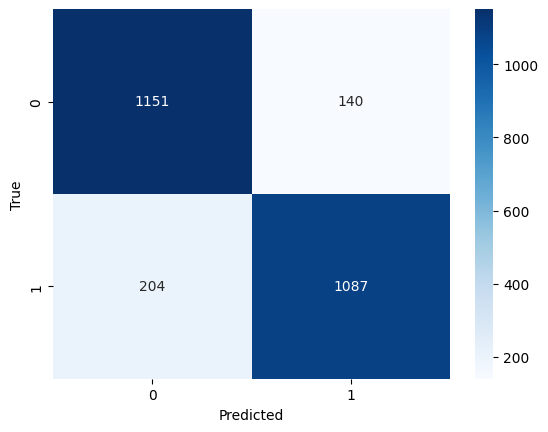

In [178]:
#@title Matriz de confusão

best_tabpfn_cm = confusion_matrix(y_test, best_tabpfn_preds_class)
plot_conf_matrix(best_tabpfn_cm)

AUC-ROC: 0.9420344985033129


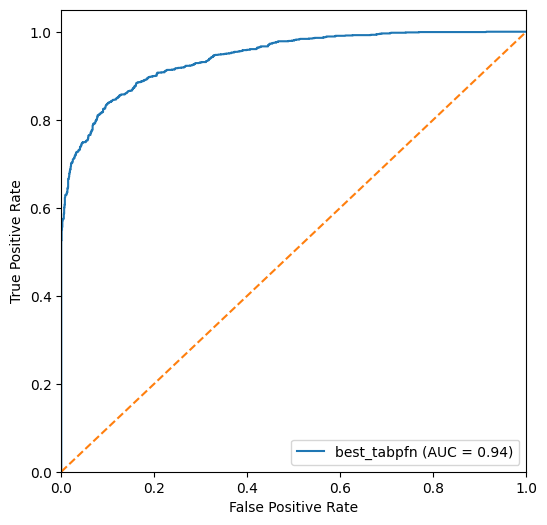

In [179]:
#@title AUC-ROC

best_tabpfn_auc = roc_auc_score(y_test, best_tabpfn_preds)
print(f"AUC-ROC: {best_tabpfn_auc}")
best_tabpfn_fpr, best_tabpfn_tpr, _ = roc_curve(y_test, best_tabpfn_preds)
plot_roc(best_tabpfn_fpr, best_tabpfn_tpr, best_tabpfn_auc, 'best_tabpfn')

In [180]:
#@title Recall, precision e f-score

best_tabpfn_recall = recall_score(y_test, best_tabpfn_preds_class)
best_tabpfn_precision = precision_score(y_test, best_tabpfn_preds_class)
best_tabpfn_f1 = f1_score(y_test, best_tabpfn_preds_class)
print(f"Recall: {best_tabpfn_recall}")
print(f"Precision: {best_tabpfn_precision}")
print(f"F1-score: {best_tabpfn_f1}")

Recall: 0.8419829589465531
Precision: 0.8859005704971475
F1-score: 0.8633836378077839


## Gradient Boosting

### Primeira execução

In [181]:
#@title Definição do modelo
gb_classifier = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
gb_classifier

GradientBoostingClassifier(random_state=42)

In [182]:
#@title Treinamento inicial
gb_classifier.fit(X_train_n, y_train)

GradientBoostingClassifier(random_state=42)

#### Avaliação inicial

In [183]:
#@title Gerando predições
gb_preds = gb_classifier.predict(X_test_n)
gb_preds_0 = 1 - gb_preds
gb_preds_scores = np.concatenate([gb_preds_0.reshape(-1, 1), gb_preds.reshape(-1, 1)], axis=1)
print(f"Predições: {gb_preds.shape}")

Predições: (2582,)


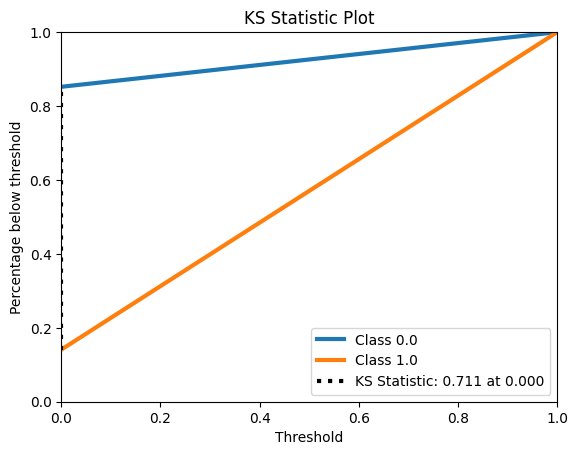

In [184]:
#@title Teste Kolmogorov-Smirnov
gb_ks = plot_ks(y_test, gb_preds_scores)

In [185]:
#@title MSE
gb_mse = mean_squared_error(y_test, gb_preds)
print(f"MSE: {gb_mse}")

MSE: 0.14446166157722473


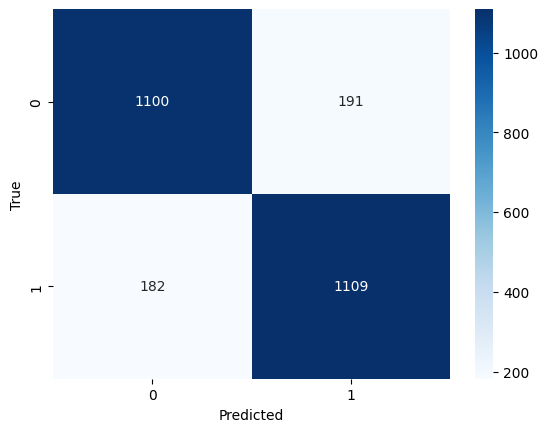

In [186]:
#@title Matriz de confusão
gb_cm = confusion_matrix(y_test, gb_preds)
plot_conf_matrix(gb_cm)

AUC-ROC: 0.8555383423702557


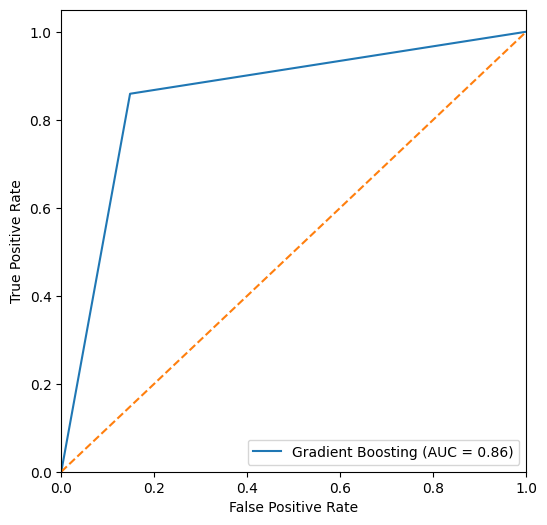

In [187]:
#@title AUC-ROC
gb_auc = roc_auc_score(y_test, gb_preds)
print(f"AUC-ROC: {gb_auc}")
gb_fpr, gb_tpr, _ = roc_curve(y_test, gb_preds)
plot_roc(gb_fpr, gb_tpr, gb_auc, 'Gradient Boosting')

In [188]:
#@title Recall, precision e f-score
gb_recall = recall_score(y_test, gb_preds)
gb_precision = precision_score(y_test, gb_preds)
gb_f1 = f1_score(y_test, gb_preds)
print(f"Recall: {gb_recall}")
print(f"Precision: {gb_precision}")
print(f"F1-score: {gb_f1}")

Recall: 0.8590240123934935
Precision: 0.8530769230769231
F1-score: 0.8560401389424932


### Otimizando com o Optuna

In [189]:
#@title Otimização do Gradient Boosting com Optuna

# A função de otimização de hiperparâmetros.
def objective_gb(trial):
    # Sugere os hiperparâmetros, conforme a especificação do projeto.
    loss = trial.suggest_categorical('loss', ['log_loss', 'exponential'])
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-2, log=True)
    n_estimators = trial.suggest_int('n_estimators', 50, 500)
    subsample = trial.suggest_float('subsample', 0.1, 1.0)
    criterion = trial.suggest_categorical('criterion', ['friedman_mse', 'squared_error'])
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
    max_depth = trial.suggest_int('max_depth', 2, 32)

    #Aqui pega os melhores parametros achados e utiliza para criar um modelo com esse parametros
    model = GradientBoostingClassifier(
        loss=loss,
        learning_rate=learning_rate,
        n_estimators=n_estimators,
        subsample=subsample,
        criterion=criterion,
        min_samples_leaf=min_samples_leaf,
        max_depth=max_depth,
        random_state=42
    )


    model.fit(X_train_n, y_train)


    y_pred = model.predict_proba(X_val_n)[:, 1]
    auc_score = roc_auc_score(y_val, y_pred)

    return auc_score

# Cria o estudo do Optuna e executa a otimização
print("Iniciando a busca pelos hiperparametros do modelo Gradient Boosting...")
study_gb = optuna.create_study(direction='maximize')
study_gb.optimize(objective_gb, n_trials=20)

print("\n--- Resultados da Otimização do Gradient Boosting ---")
print("Melhores hiperparametros encontrados:")
print(study_gb.best_params)
print("\nMelhor Area AUC no conjunto de validação:")
print(study_gb.best_value)

[I 2025-08-11 09:22:51,741] A new study created in memory with name: no-name-3e1cae54-8529-4300-9952-3f338e42964d


Iniciando a busca pelos hiperparametros do modelo Gradient Boosting...


[I 2025-08-11 09:22:56,193] Trial 0 finished with value: 0.8909588744978654 and parameters: {'loss': 'log_loss', 'learning_rate': 0.00014438611309233368, 'n_estimators': 300, 'subsample': 0.8487950310529322, 'criterion': 'friedman_mse', 'min_samples_leaf': 1, 'max_depth': 4}. Best is trial 0 with value: 0.8909588744978654.
[I 2025-08-11 09:23:03,283] Trial 1 finished with value: 0.922041083469938 and parameters: {'loss': 'log_loss', 'learning_rate': 0.0009334020190904876, 'n_estimators': 248, 'subsample': 0.4686931018054624, 'criterion': 'friedman_mse', 'min_samples_leaf': 7, 'max_depth': 23}. Best is trial 1 with value: 0.922041083469938.
[I 2025-08-11 09:23:06,101] Trial 2 finished with value: 0.92179999879908 and parameters: {'loss': 'log_loss', 'learning_rate': 0.006193549858729805, 'n_estimators': 194, 'subsample': 0.21247808606854707, 'criterion': 'squared_error', 'min_samples_leaf': 6, 'max_depth': 19}. Best is trial 1 with value: 0.922041083469938.
[I 2025-08-11 09:23:21,192] T


--- Resultados da Otimização do Gradient Boosting ---
Melhores hiperparametros encontrados:
{'loss': 'exponential', 'learning_rate': 0.008703935345289956, 'n_estimators': 498, 'subsample': 0.7008820471693449, 'criterion': 'squared_error', 'min_samples_leaf': 4, 'max_depth': 26}

Melhor Area AUC no conjunto de validação:
0.9337305375917953


### Avaliação com melhor modelo

In [190]:
#@title Criando melhor modelo

best_gb = GradientBoostingClassifier(
    loss=study_gb.best_params['loss'],
    learning_rate=study_gb.best_params['learning_rate'],
    n_estimators=study_gb.best_params['n_estimators'],
    subsample=study_gb.best_params['subsample'],
    criterion=study_gb.best_params['criterion'],
    min_samples_leaf=study_gb.best_params['min_samples_leaf'],
    max_depth=study_gb.best_params['max_depth'],
    random_state=42
)
best_gb

GradientBoostingClassifier(criterion='squared_error',
                           learning_rate=0.008703935345289956,
                           loss='exponential', max_depth=26, min_samples_leaf=4,
                           n_estimators=498, random_state=42,
                           subsample=0.7008820471693449)

In [191]:
#@title Treinando melhor modelo

best_gb.fit(X_train_n, y_train)

GradientBoostingClassifier(criterion='squared_error',
                           learning_rate=0.008703935345289956,
                           loss='exponential', max_depth=26, min_samples_leaf=4,
                           n_estimators=498, random_state=42,
                           subsample=0.7008820471693449)

In [192]:
#@title Gerando predições

best_gb_preds = best_gb.predict(X_test_n)
best_gb_preds_0 = 1 - best_gb_preds
best_gb_preds_scores = np.concatenate([best_gb_preds_0.reshape(-1, 1), best_gb_preds.reshape(-1, 1)], axis=1)
best_gb_preds.shape

(2582,)

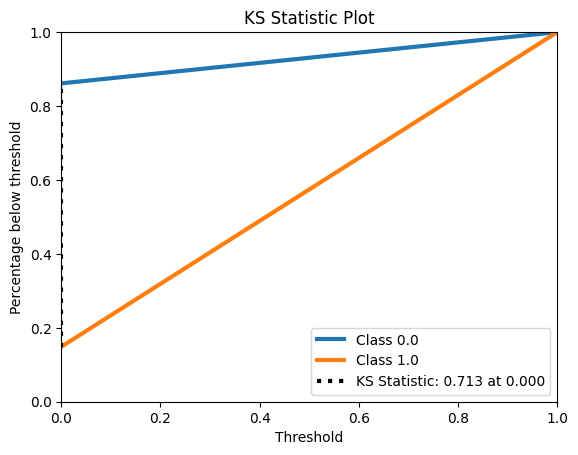

In [193]:
#@title Teste Kolmogorov-Smirnov

best_gb_ks = plot_ks(y_test, best_gb_preds_scores)

In [194]:
#@title MSE

best_gb_mse = mean_squared_error(y_test, best_gb_preds)
print(f"MSE: {best_gb_mse}")

MSE: 0.14368706941604614


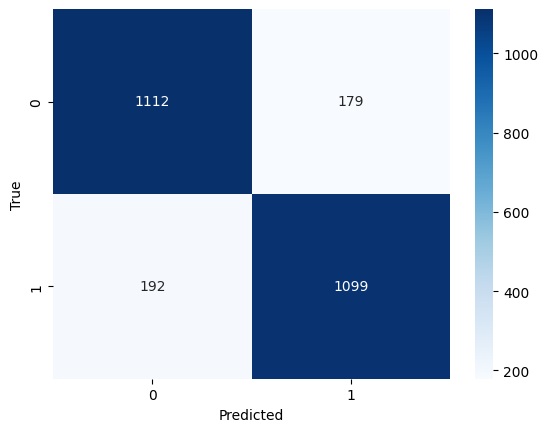

In [195]:
#@title Matriz de confusão

best_gb_cm = confusion_matrix(y_test, best_gb_preds)
plot_conf_matrix(best_gb_cm)

In [196]:
#@title AUC-ROC

best_gb_auc = roc_auc_score(y_test, best_gb_preds)
print(f"AUC-ROC: {best_gb_auc}")

AUC-ROC: 0.8563129357087528


In [197]:
#@title Recall, precision e f1-score

best_gb_recall = recall_score(y_test, best_gb_preds)
best_gb_precision = precision_score(y_test, best_gb_preds)
best_gb_f1 = f1_score(y_test, best_gb_preds)
print(f"Recall: {best_gb_recall}")
print(f"Precision: {best_gb_precision}")
print(f"F1-score: {best_gb_f1}")

Recall: 0.8512780790085205
Precision: 0.8599374021909233
F1-score: 0.8555858310626703


# Avaliação final

## Comparação de métricas de todos os modelos